In [16]:
# imports
import torch
import torch.nn as nn
import math
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from dataset import dataset
from model import pressureInsolesTransformer
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
# Dataloading
path_list = ['../data/subject1.pth', '../data/subject2.pth', '../data/subject3.pth', '../data/subject4.pth', '../data/subject5.pth',
                        '../data/subject6.pth', '../data/subject7.pth', '../data/subject8.pth', '../data/subject9.pth', '../data/subject10.pth']
data = dataset(path_list)
print(data.labels)
batch_size = 10
train_set, validation_set, test_set = random_split(data, [0.6, 0.2, 0.2])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [38]:
# Training
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = []

    for data, label in iter(loader):
        data = data.permute((0,2,1)).to(torch.float32).to(device)
        label = label.to(device).to(torch.long)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.item())
        
    return running_loss


def validate(model, loader, criterion, device, best_loss=float('inf'), save_path="best_model.pth"):
    model.eval()
    running_loss = []

    with torch.no_grad():
        for data, label in iter(loader):
            data = data.permute((0,2,1)).to(torch.float32).to(device)
            label = label.to(device).to(torch.long)
            outputs = model(data)
            loss = criterion(outputs, label)
            running_loss.append(loss.item())
    val_loss = sum(running_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), save_path)

    return running_loss, best_loss

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device):
    best_loss = float('inf')
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        val_loss, best_loss = validate(model, val_loader, criterion, device, best_loss, save_path="best_model.pth")
        val_losses.append(val_loss)
        scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {sum(train_loss):.4f}"
              f"| Val Loss: {sum(val_loss):.4f}", end="\r")
    return train_losses, val_losses

def reinit_transformer_weights(model, d_model):
    for module in model.modules():
        if isinstance(module, nn.MultiheadAttention):
            nn.init.xavier_uniform_(module.in_proj_weight)
            if module.in_proj_bias is not None:
                nn.init.zeros_(module.in_proj_bias)

            nn.init.xavier_uniform_(module.out_proj.weight)
            if module.out_proj.bias is not None:
                nn.init.zeros_(module.out_proj.bias)

        elif isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

        elif isinstance(module, nn.LayerNorm):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=1/math.sqrt(d_model))

if __name__ == "__main__":
    device = torch.device("mps")
    epochs = 40
    
    model = pressureInsolesTransformer(
    input_dim=302,
    latent_dim=32,
    num_classes=10,
    num_encoder_layers=6,
    nhead=16,
    dim_feedforward=1024,
    dropout=0.1,
    seq_len=287
    )
    reinit_transformer_weights(model, 1024)
    model.to(device)   
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)
    scheduler1 = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, total_iters=20)
    scheduler2 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    scheduler = optim.lr_scheduler.SequentialLR(optimizer, [scheduler1, scheduler2], [21])
    train_losses, val_losses = train_model(model, train_loader, validation_loader, criterion, optimizer, scheduler, epochs, device)



[2.266512058932206, 1.1526618157995159, 0.40700631871305665, 0.1817220550608532, 0.09860198639718623, 0.06286101251969049, 0.04442952828610252, 0.03382830222233616, 0.026219534093578314, 0.021033212044758016, 0.017197013736285013, 0.014477811577119705, 0.012546162361857193, 0.010623479635326257, 0.009157330704981396, 0.008162445641636592, 0.007047325573411995, 0.0062473794076077895, 0.005536634242162108, 0.004967747870350963, 0.004350843353614468, 0.003932440388498121, 0.003462846637783765, 0.0031972781449941725, 0.002889548176457977, 0.002644375041889926, 0.002420069439063684, 0.002210336140204414, 0.002052262814811848, 0.00189310231081467, 0.001777565352626723, 0.0016230174765825786, 0.001517649215108169, 0.0013985022197975296, 0.0013050746578113016, 0.00123754790020657, 0.0011391753706165813, 0.0010630322584143743, 0.0009937549917155813, 0.0009485587185642136]
[1.9918887278972528, 0.49323602135364825, 0.15451083676173136, 0.06778351809733953, 0.03671723288985399, 0.0235343615596111,

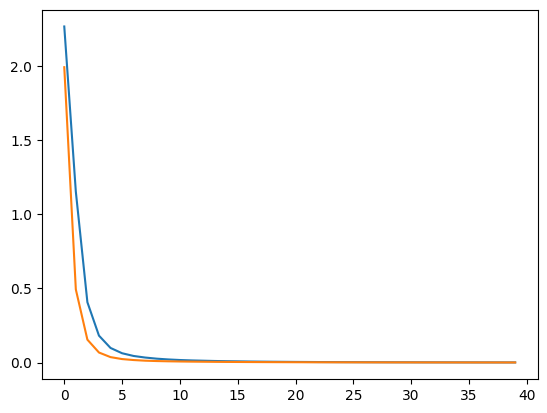

In [39]:
# Plotting
print([sum(x)/len(x) for x in train_losses])
print([sum(x)/len(x) for x in val_losses])
plt.plot([sum(x)/len(x) for x in train_losses])
plt.plot([sum(x)/len(x) for x in val_losses])
print(min([sum(x)/len(x) for x in val_losses]))

In [40]:
# Testing
def test_model(model, test_loader):
    correct = 0
    total = 0
    for data, labels in iter(test_loader):
        data = data.permute((0,2,1)).to(torch.float32).to(device)
        labels = labels.to(device).to(torch.long)
        outputs = model(data)
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    return correct / total
        

model_path = "./best_model.pth"
model.to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
accuracy = test_model(model, test_loader)
print(accuracy)

0.9376623376623376
